# Deep Neural networks/Multi-layer perceptrons for Sedimentation rate[cm/yr] predictions 

## Train Neural Network

Here we would have three pipelines atleast: One for the regression, one for classification and one for bayesian neural network

### Monte carlo dropout: regression

In [3]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from os import path, makedirs
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)

#tf.config.experimental.set_memory_growth(physical_devices[0], True) # solves some GPU memory issues 
np.random.seed(42)
tf.random.set_seed(42)

#print(physical_devices)

2022-10-20 12:05:48.081427: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [4]:
feature_path = Path(Path() / "SedFeaturesnoNAN_nolimit")
features = np.load(Path(feature_path / "numpy_features.npy"))
labels = np.load(Path(feature_path / "numpy_labebels.npy"))
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)
#lat_labels = np.load(Path(feature_path / "numpy_latitudes_labels.npy")).astype(np.float)
#lon_labels = np.load(Path(feature_path / "numpy_longitudes_labels.npy")).astype(np.float)


#Norm Features
features = np.divide((features - X_mean),X_std)

with open(Path(feature_path / "sorted_features.txt"), "rb") as fp:
    feature_names = pickle.load(fp)

#feature_selection = pd.read_csv(Path("Selection_374_Chlor.csv")).values
# feature_selection = pd.read_csv(Path("restrepoHighResFeaturesRaw-50.txt")).values


#filter and clean features/labels
#Features from list
# selection_filter = np.zeros(features.shape[1], dtype=bool)
# for idx, feature_name in enumerate(feature_names):
#     if feature_name in feature_selection: # drop '.nc' from feature names #drop .grd
#         selection_filter[idx] = True

#Exclude Feature
#selection_filter = np.ones(features.shape[1])
# for idx, feature_name in enumerate(feature_names):
#     if feature_name[:-3] == "MY1DMM_CHLORA_2020-08-01":
#         selection_filter[idx] = 0

# selection_filter = selection_filter.astype(bool)

prediction_limit = 5000

# features = features[:,selection_filter]
features = features[labels<prediction_limit,:] #take only TOC < 5% 
# lat_labels = lat_labels[labels<prediction_limit]
# lon_labels = lon_labels[labels<prediction_limit]
labels = labels[labels<prediction_limit]
# labels[labels>prediction_limit] = prediction_limit

#Drop features with NaNs
nan_rows = np.isnan(features).any(axis=0)
np.save("FeatureNanRows",nan_rows)
features = features[:,~nan_rows]
print(nan_rows)


# #OR fill in NaNs with random
# nan_fill = np.random.rand(features.shape[0],features.shape[1])*2-1
# features[np.isnan(features)] = nan_fill[np.isnan(features)]

# suffle features/labels
shuffle_idx = np.random.mtrand.randint(low = 0, high = len(labels), size = len(labels))
features = features[shuffle_idx,:]
labels = labels[shuffle_idx]

#features = encoded_features.numpy()
print(features.shape)


# # #PCA
# pca = PCA (0.95) #95% of the variance is retained
# pca.fit(features)
# features = pca.transform(features)
# print(features.shape)

#taking the log of labels so that the order of maginitude between deep oceans and the coasts is reduced
#loglabels=np.log10(labels)

model = [None]*10
MAE = []
corrcoef = []
kf = KFold(n_splits=10)
mc_samples = 50


[False False False ... False False False]
(2782, 1845)


In [10]:
#features = encoded_features.numpy()
#early stopping and LR-scheduling callbacks
#checkpoint_cb = keras.callbacks.ModelCheckpoint('TOC_nn.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "loss", patience = 200, restore_best_weights = True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor = "loss", factor = 0.8, patience = 40, min_lr = 0.000001)
do_rate = 0.2
num_nodes = 50
    
model_seed = keras.models.Sequential()
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))




model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))





model_seed.add(keras.layers.Dense(1, activation = "relu"))

model_seed.build([None,features.shape[1]])


In [ ]:

#%%timeit -n 1 -r 1
#fold = 0
#for train, test in kf.split(features, labels): #startification/10fold
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=1)    
#print("computing fold " + str(fold+1))




model = keras.models.clone_model(model_seed)
model.set_weights(model_seed.get_weights())
model.compile(loss = "mean_absolute_error",
             optimizer = keras.optimizers.Nadam(learning_rate = 0.01),
             metrics = [["RootMeanSquaredError"]])
 
#Final run with early stopping callback
print("running main training round")
 
 
history = model.fit(features_train, labels_train,  epochs = 10000, batch_size= 70, 
                      callbacks = [ early_stopping_cb,lr_scheduler],verbose =2,validation_split=0.2)#
 

In [25]:
#MC Dropout
probs_stack = np.stack([model(features_test,training = True) for sample in range(mc_samples)]) 
probs_stack = probs_stack.reshape([probs_stack.shape[0],probs_stack.shape[1]])
np.savetxt("probs_stack_regression.txt", probs_stack.T)
np.savetxt("labels_test_regression.txt", labels_test)
predictions = tf.squeeze(probs_stack.mean(axis = 0))
np.savetxt("predictions_regression.txt", predictions)
corrcoef.append(np.corrcoef(predictions, labels_test)[0,1])
MAE.append(mean_absolute_error(labels_test,predictions))
 
history_df = pd.DataFrame(history.history)#
#print(history_df)
#print("best val accuracy: " + str(np.max(history_df.val_accuracy)))
print("test MAE:" + str(MAE))
print("test correlation coeficient:" + str(corrcoef))
print("     ----     ")
#fold = fold+1

test MAE:[92.40137333960874, 99.12897195408404, 99.12897195408404]
test correlation coeficient:[0.7396501054759339, 0.6654294821758706, 0.6654294821758706]
     ----     


In [24]:
features.shape

(2782, 100)

Correlation Coefficient: 0.7025397938259023
MAE: 95.7651726468464
0.6654294821758706
(2782,)
(557,)


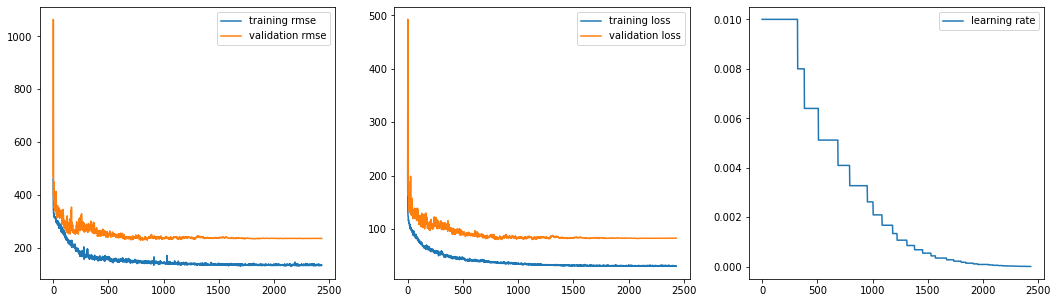

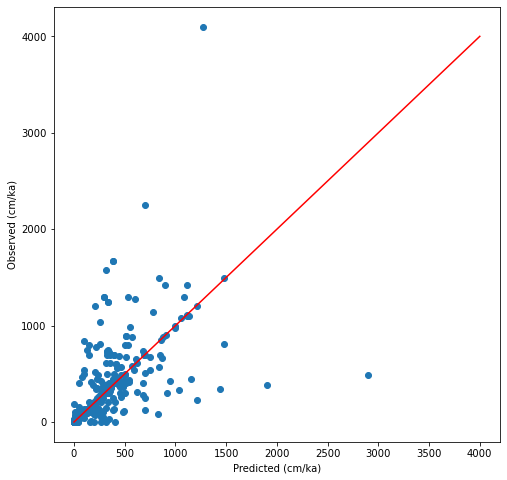

In [23]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=[18,5])
plt.subplot(131)
plt.plot(history_df.root_mean_squared_error)
plt.plot(history_df.val_root_mean_squared_error)
plt.legend(["training rmse", "validation rmse"])
#plt.ylim([100,4000])
plt.subplot(132)
plt.plot(history_df.loss)
plt.plot(history_df.val_loss)
plt.legend(["training loss", "validation loss"])
#plt.ylim([20,400])
plt.subplot(133)
plt.plot(history_df.lr)
plt.legend(["learning rate"])

print("Correlation Coefficient: "+str(np.sum(corrcoef)/len(corrcoef)))
print("MAE: " +str(np.sum(MAE)/len(MAE)))


plt.figure(figsize=[8,8])
#plt.clf()
plt.scatter(predictions,labels_test)
x = np.linspace(0,4000)
plt.plot(x, x, 'r')
plt.xlabel("Predicted (cm/ka)")
plt.ylabel("Observed (cm/ka)")
print(np.corrcoef(predictions,labels_test)[0,1])

dirname = Path("Sed_regresion_083_RestrepoFeats_AllVS0.2_Test")
if not path.isdir(dirname):
    makedirs(dirname)
 
# for idx, model in enumerate(model):
model_name = "Model_nolimitnonan_Test"  + ".h5"
model.save(Path(dirname / model_name))
    
print(labels.shape)
print(labels_test.shape)

#error=[]
#error = np.abs(model.predict(features[:,:])[:,0]-labels)
#error = np.array(error)

#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#df = pd.DataFrame({'Latitude': lat_labels, 'Longitude':lon_labels, 'Error': error})
#geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
#gdf = GeoDataFrame(df, geometry=geometry)  
#gdf.plot(ax = world.plot(figsize = (20, 12)), column = df["Error"],legend = True, legend_kwds={"label":"{error in prediction}"});


#execfile("Make_Global_Predictions_regression.py")



## Regression

In [14]:
#%%timeit -n 1 -r 1
#fold = 0
#for train, test in kf.split(features, labels): #startification/10fold
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=1)    
#print("computing fold " + str(fold+1))

In [27]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(features_train, labels_train)
features.shape

(2782, 100)

(557,)
(557, 100)
0.600710403688208


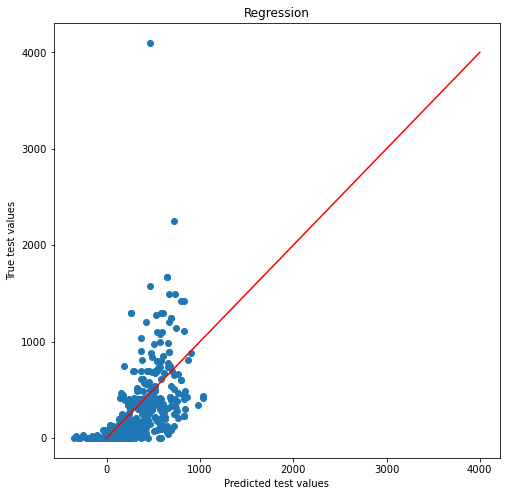

In [28]:
print(reg.predict(features_test).shape)
print(features_test.shape)
plt.figure(figsize=[8,8])
plt.scatter(reg.predict(features_test), labels_test)
plt.title("Regression")
plt.xlabel("Predicted test values")
plt.ylabel("True test values")
x = np.linspace(0,4000)
plt.plot(x, x, 'r')
print(np.corrcoef(reg.predict(features_test), labels_test)[0,1])

## Auto encoder

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler

In [6]:
features.shape

(2782, 1845)

In [7]:
# This is the dimension of the original space
input_dim = features.shape[1]

# This is the dimension of the latent space (encoding space)
latent_dim = 1

encoder = Sequential([
    Dense(1000, activation='relu', input_shape=(input_dim,)),
    Dense(700, activation='relu'),
    Dense(400, activation='relu'),
    Dense(200, activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(latent_dim, activation='relu')
])

decoder = Sequential([
    Dense(50, activation='relu', input_shape=(latent_dim,)),
    Dense(100, activation='relu'),
    Dense(200, activation='relu'),
    Dense(400, activation='relu'),
    Dense(700, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(input_dim, activation=None)
])

2022-10-20 12:06:06.779766: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 12:06:06.781110: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
model_history = autoencoder.fit(features, features, epochs=1000, batch_size=70, callbacks = [ early_stopping_cb,lr_scheduler],verbose =2)

plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

NameError: name 'features_train' is not defined

Text(0, 0.5, 'Latent Dimension 2')

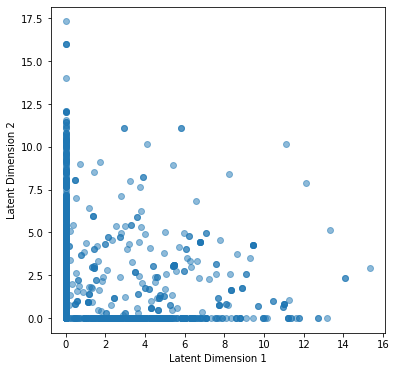

In [18]:
encoded_features = encoder(features)
plt.figure(figsize=(6,6))
plt.scatter(encoded_features[:, 44], encoded_features[:, 9], alpha=.5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

In [12]:
np.linalg.norm(features - autoencoder(features).numpy())

949.6636639737894

## Encoder
If we make the latent dimension to one, then we can train the autoencoder with the features alone and then finettune the encoder to give us sedimentation rates.

Problem: As we keep decreasing the latent dimension, the model is difficult to fit. Hence thee weights that were set in the encoder during the training of the autoencoder is not great. When the mdoel is fine tuned with the training data then the data does not fit well, when compared to training an entire network. 

In [ ]:
encoder.save("encoder.h5")
autoencoder.save("autoencoder.h5")

In [87]:
from tensorflow import keras
new_encoder = keras.models.load_model("encoder.h5")

In [88]:
new_autoencoder = keras.models.load_model("autoencoder.h5")
np.linalg.norm(features - new_autoencoder(features).numpy())

949.6636639737894

In [89]:
new_autoencoder.layers

In [90]:
weights_list = new_autoencoder.weights
for i in range(0,14,2):
    l = []
    x = weights_list[i].numpy()
    y = weights_list[i+1].numpy()
    l.append(x)
    l.append(y)
    new_encoder.layers[int(i/2)].set_weights(l)


In [91]:
new_encoder.layers

In [92]:
new_encoder(features_train).shape

TensorShape([2225, 1])

In [93]:
new_encoder.compile(loss='mse', optimizer="adam")
new_model_history = new_encoder.fit(features_train, labels_train, epochs=1000, batch_size=70, callbacks = [ early_stopping_cb,lr_scheduler],verbose =2)

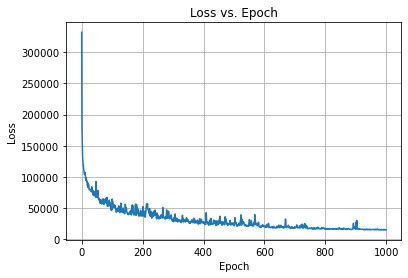

In [94]:
plt.plot(new_model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

In [103]:
predictions = new_encoder(features_test)
predictions = predictions.numpy().flatten()

0.6640683838913086
(2782,)
(557,)


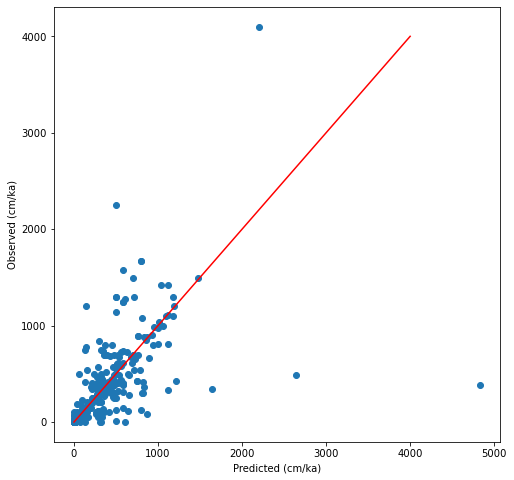

In [106]:
plt.figure(figsize=[8,8])
#plt.clf()
plt.scatter(predictions,labels_test)
x = np.linspace(0,4000)
plt.plot(x, x, 'r')
plt.xlabel("Predicted (cm/ka)")
plt.ylabel("Observed (cm/ka)")
print(np.corrcoef(predictions,labels_test)[0,1])



    
print(labels.shape)
print(labels_test.shape)
